In [1]:
import json
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics 
import seaborn as sns
from numpy.random import randn
from statistics import mode
%matplotlib inline

In [2]:
pupils = json.load(open('pupils.json', 'r'))    # result will be a python dictionary

#jeder entry ist ein schüler: zB data[0]
len(pupils)
#2715

2996

# Aufbau der Daten

* _id
* classId
* userId
* companyId
* partner
* lang
* username
* shownTaskSeries
* currentTaskSeries
* solvedTaskSeries
    * [] liste mit allen solvedTaskSeries
       * sectionIdx
       * subSectionIdx
       * stage
       * wentActive
       * lastActive
       * created
       * taskSeriesId
       * currentSections
          * [] Liste mit allen Sections
             * currentSubSections
                * []
                   * duration (in sekunden)
                   * exercise
                      * state:
                         * text bei freitext in p tags
                         * 0, 1, 0... bei survey
                         * false, true, false bei MC
                      * submitted: true
                      * history: wahrscheinlich alte versionen bei freetext
                      * subType “freetext”, “survey”, “multipleChoice”
                      * falseAttempts bei MC: bool array mit erster lösung
                      * evaluation: (bool) bei freetext und MC
                         * “false” bei mc wenn falsche lösung und keine tipps → direkt musterlösung
                         * “correct” bei mc wenn richtige lösung
                         * “pending” bei freitext, wenn lehrer noch nicht bewertet
                      * rating: bei freetext
* revisions
   * _id
   * taskSeriesId
   * sectionIdx
   * subSectionIdx
   * begin
   * accepted
* workspaceContent
   * type: 'revision'
   * 'id': 'For-1_0_1'
* chat
   * messages
      * [] liste mit allen messages
         * date
         * sentBy: zB "auto"
         * message: string mit message
   * readUpTo
* assists
* experience
* lastNotificationUpdate

# Klassen wählen, die das KI Paket gemacht haben

In [3]:
# taskseriesIDs vom KI Paket:
KI_taskseries_ids = ["AI-1-v2", "AI-2-v2", "AI-3-v2", "AI-4-v2", "ML-1", "ML-2", "ML-3", "Classification-1", "Clustering-1", "Classification-2", "Clustering-2", "LimitsML", "EvalML", "Impact-1", "Impact-2", "Impact-3", "Impact-4", "AIClosing"]

classIDsKI = []
pupilsKI = []

for pupilnumber in range(len(pupils)): #für jeden schüler
    for tasknumber in range(len(pupils[pupilnumber]["solvedTaskSeries"])): #für jede seiner tasks
        if("taskSeriesId" in pupils[pupilnumber]["solvedTaskSeries"][tasknumber].keys()):
            if(pupils[pupilnumber]["solvedTaskSeries"][tasknumber]["taskSeriesId"] in KI_taskseries_ids):
                for sectionnumber in range(len(pupils[pupilnumber]["solvedTaskSeries"][tasknumber]["currentSections"])): #für diese tasks, alle sections
                    for subsectionnumber in range(len(pupils[pupilnumber]["solvedTaskSeries"][tasknumber]["currentSections"][sectionnumber]["currentSubSections"])):
                        if("exercise" in pupils[pupilnumber]["solvedTaskSeries"][tasknumber]["currentSections"][sectionnumber]["currentSubSections"][subsectionnumber].keys()):
                            if pupils[pupilnumber]["classId"] not in classIDsKI:
                                classIDsKI.append(pupils[pupilnumber]["classId"])
                            if pupils[pupilnumber] not in pupilsKI:
                                pupilsKI.append(pupils[pupilnumber])

KI_classes = {classID: {"count": 0} for classID in classIDsKI}

for pupil in pupilsKI:
    KI_classes[pupil["classId"]]["count"] += 1

print(KI_classes)
print("")

# Jetzt nur die Klassen mit genügend SuS auswählen
final_pupils_KI = []
min_class_size = 10

for pupil in pupilsKI:
    if(KI_classes[pupil["classId"]]["count"] >= min_class_size):
        final_pupils_KI.append(pupil)

print("Zur Zeit gibt es " + str(len(final_pupils_KI)) + " sus, die das KI Paket bearbeitet haben")

{'uxfuiLT4xZA6yvE6L': {'count': 2}, 'qFEyvypMn4sAwLwtc': {'count': 26}, 'y7j9eKDPsqNkAycuy': {'count': 1}, 'NXCw6MMERYbnzdTjc': {'count': 1}, '6Z2MmkKQKebb7nz8P': {'count': 3}, '4fyXxCKaLbCBaPbYE': {'count': 1}, 'xYWgeSPkADwSmhdmm': {'count': 2}, 'GkQSJvPTRWsLnpyR9': {'count': 14}, '7cWBWtLEcLSYDygDc': {'count': 1}}

Zur Zeit gibt es 40 sus, die das KI Paket bearbeitet haben


## DF mit classId und pupilId konstruieren

In [4]:
class_list = [{"pupilId": pupil["_id"], "classId": pupil["classId"]} for pupil in final_pupils_KI]
class_df = pd.DataFrame(class_list)

class_df.head()

,pupilId,classId
0,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc
1,sqBXKssFvS8pFYAMv,qFEyvypMn4sAwLwtc
2,Kd6FuRsrq6QvPrkKp,qFEyvypMn4sAwLwtc
3,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc
4,ZTvPk2i77LDC8pFmu,qFEyvypMn4sAwLwtc


#

# Alle von SuS bearbeitete Aufgaben im KI Paket in einen DF

In [5]:
tasktypes = ["blockly", "multipleChoice", "freetext", "survey", "inputField", "surveySlider", "noTask"]
exercise_keys = ['state', 'submitted', 'subType', 'evaluation', 'falseAttempts', 'hintsTaken', 'rating', 'teacherFeedback', "history"]

# TODO: nehme hier alle Aufgaben von SuS, die das KI Paket bearbeitet haben, nicht nur diese Inhalte --> einschränken?

columns = ["pupilId", "taskId", "taskSeriesId", "duration"] + exercise_keys
pupil_df = pd.DataFrame(columns=columns)

row_nr = 0
for pupil in final_pupils_KI:
    for task in pupil["solvedTaskSeries"]:
        sec_nr = 1
        for section in task["currentSections"]:
            subsec_nr = 1
            for subsection in section["currentSubSections"]:
                # eine neue Zeile hinzufügen für jede bearbeitete Aufgabe und id columns füllen
                #df = df.append({"pupilId": pupil["_id"], "taskId": str(task["taskSeriesId"])+"-"+str(sec_nr)+"-"+str(subsec_nr),'taskSeriesId': task["taskSeriesId"], "sec_nr": sec_nr, "subsec_nr": subsec_nr}, ignore_index=True)
                pupil_df = pupil_df.append({"pupilId": pupil["_id"], "taskId": str(task["taskSeriesId"])+"-"+str(sec_nr)+"-"+str(subsec_nr),'taskSeriesId': task["taskSeriesId"], "duration": subsection["duration"]}, ignore_index=True)
                subsec_nr += 1
                if("exercise" in subsection.keys()):
                    # hier wird der eigentliche state der aufgabe in die reihe eingetragen
                    for key in subsection["exercise"].keys():
                        pupil_df.at[row_nr, key] = subsection["exercise"][key]
                row_nr += 1
            sec_nr +=1
    
# aufgaben loswerden, die nicht submitted wurden!
pupil_df.dropna(subset=['submitted'], inplace=True)

#die antworten der einen falschen aufgabe berichtigen
for index in pupil_df.index:
    if(pupil_df.loc[index, "taskId"] == "Classification-2-1-5"):
        if ("2" in str(pupil_df.loc[index, "falseAttempts"])): #die SuS, die es eigentlich richtig hatten
            pupil_df.loc[index, "falseAttempts"] = np.nan
            pupil_df.loc[index, "evaluation"] = "correct"
        elif(pupil_df.loc[index, "pupilId"]=="gooproPtWeTH6dtcB"): #der eine schüler, der es falsch hatte
            pupil_df.loc[index, "falseAttempts"] = [str(pupil_df.loc[index, "state"])]
            pupil_df.loc[index, "evaluation"] = "false"

pupil_df.head()


,pupilId,taskId,taskSeriesId,duration,state,submitted,subType,evaluation,falseAttempts,hintsTaken,rating,teacherFeedback,history
0,bniRycMi5bwrXjvGy,AI-1-v2-1-1,AI-1-v2,40,92,True,surveySlider,NaN,NaN,NaN,NaN,NaN,[]
1,bniRycMi5bwrXjvGy,AI-1-v2-1-2,AI-1-v2,119,"<p>Künstliche Intelligenz ist ein Algorithmus,...",True,freetext,correct,NaN,NaN,"{'content': 3, 'format': 5, 'creativity': 4}","Inhaltlich gut, etwas genauer antworten. Muste...",[]
2,bniRycMi5bwrXjvGy,AI-1-v2-2-1,AI-1-v2,268,"[0, 0, 1, 0, 0]",True,survey,NaN,NaN,NaN,NaN,NaN,[]
4,bniRycMi5bwrXjvGy,AI-2-v2-1-1,AI-2-v2,94,"[True, True, False, True]",True,multipleChoice,correct,NaN,NaN,NaN,NaN,[]
6,bniRycMi5bwrXjvGy,AI-3-v2-1-1,AI-3-v2,43,"[False, False, False]",True,multipleChoice,correct,NaN,NaN,NaN,NaN,[]


## DF mit taskSeries bauen

In [6]:
#taskSeries Laden
taskSeries = json.load(open('taskSeries.json', 'r'))    # result will be a python dictionary

In [7]:
#KI_taskseries_ids = ["AI-1-v2", "AI-2-v2", "AI-3-v2", "AI-4-v2", "ML-1", "ML-2", "ML-3", "Classification-1", "Clustering-1", "Classification-2", "Clustering-2", "LimitsML", "EvalML", "Impact-1", "Impact-2", "Impact-3", "Impact-4", "AIClosing"]

interaction_subtypes = ['multipleChoice', 'blockly', 'surveySlider', 'survey', 'inputField', 'freetext']
columns = ["taskId", "question", "answers", "minLabel", "maxLabel", "hints", "sampleSolution"]
task_df = pd.DataFrame(columns=columns)

row_nr = 0
for taskSerie in taskSeries:
    sec_nr = 1
    if taskSerie["_id"] in KI_taskseries_ids:
        for section in taskSerie["sections"]:
            subsec_nr = 1
            for subsection in section["subSections"]:
                for elem in subsection["elements"]:
                    if(elem["subType"] in interaction_subtypes):
                        task_df = task_df.append({"taskId": str(taskSerie["_id"])+"-"+str(sec_nr)+"-"+str(subsec_nr), "question": elem["question"]["de"]}, ignore_index=True)
                        #task_df = task_df.append({"taskId": str(taskSerie["_id"])+"-"+str(sec_nr)+"-"+str(subsec_nr),'taskSeriesId': taskSerie["_id"], "sec_nr": sec_nr, "subsec_nr": subsec_nr, "subType": elem["subType"], "question": elem["question"]["de"]}, ignore_index=True)
                        if(elem["subType"] == "surveySlider"):
                            task_df.at[row_nr, "minLabel"] = elem["specificData"]["minLabel"]["de"]
                            task_df.at[row_nr, "maxLabel"] = elem["specificData"]["maxLabel"]["de"]
                        elif(elem["subType"] == "freetext"):
                            task_df.at[row_nr, "sampleSolution"] = elem["sampleSolution"]["de"]
                        elif(elem["subType"] == "survey"):
                            task_df.at[row_nr, "answers"] = elem["specificData"]["answers"]
                        elif(elem["subType"] == "multipleChoice"):
                            task_df.at[row_nr, "answers"] = elem["specificData"]["answers"]
                            task_df.at[row_nr, "sampleSolution"] = elem["sampleSolution"]["universal"]
                            if(len(elem["hints"]) > 0):
                                task_df.at[row_nr, "hints"] = elem["hints"][0]["de"]
                        elif(elem["subType"] == "inputField"):
                            task_df.at[row_nr, "sampleSolution"] = elem["sampleSolution"]["universal"]
                            if(len(elem["hints"]) > 0):
                                task_df.at[row_nr, "hints"] = elem["hints"][0]["de"]
                        row_nr += 1
                subsec_nr +=1
            sec_nr +=1
            
task_df.head()

,taskId,question,answers,minLabel,maxLabel,hints,sampleSolution
0,AI-1-v2-1-1,"Wie gut weißt du schon, was KI ist?",NaN,Gar nicht,Sehr gut,NaN,NaN
1,AI-1-v2-1-2,Was ist deiner Meinung nach Künstliche Intelli...,NaN,NaN,NaN,NaN,Die Schülerinnen und Schüler (SuS) sollen besc...
2,AI-1-v2-2-1,Wie viele deiner Zeichnungen hat die KI erkann...,"[{'de': '0', 'en-US': '0'}, {'de': '1-2', 'en-...",NaN,NaN,NaN,NaN
3,AI-2-v2-1-1,"Kannst du erkennen, wo KI überall drin steckt?...",[{'de': 'Der Newsfeed eines Social Network nut...,NaN,NaN,"Denk an die Beispiele, die wir uns am Anfang a...","[True, True, False, True]"
4,AI-3-v2-1-1,Was für Sachen können KI-Anwendungen?,"[{'de': 'Die Anwendung, die den Facebook-Feed ...",NaN,NaN,"Kann überhaupt eine dieser Anwendungen etwas, ...","[False, False, False]"


## DF mergen

In [8]:
new_df = pd.merge(pupil_df, task_df, on='taskId')
new_df.drop(columns=['history'], inplace=True)

In [9]:
df = pd.merge(class_df, new_df, on="pupilId")
df.head()

,pupilId,classId,taskId,taskSeriesId,duration,state,submitted,subType,evaluation,falseAttempts,hintsTaken,rating,teacherFeedback,question,answers,minLabel,maxLabel,hints,sampleSolution
0,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-1-v2-1-1,AI-1-v2,40,92,True,surveySlider,NaN,NaN,NaN,NaN,NaN,"Wie gut weißt du schon, was KI ist?",NaN,Gar nicht,Sehr gut,NaN,NaN
1,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,AI-1-v2,119,"<p>Künstliche Intelligenz ist ein Algorithmus,...",True,freetext,correct,NaN,NaN,"{'content': 3, 'format': 5, 'creativity': 4}","Inhaltlich gut, etwas genauer antworten. Muste...",Was ist deiner Meinung nach Künstliche Intelli...,NaN,NaN,NaN,NaN,Die Schülerinnen und Schüler (SuS) sollen besc...
2,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-1-v2-2-1,AI-1-v2,268,"[0, 0, 1, 0, 0]",True,survey,NaN,NaN,NaN,NaN,NaN,Wie viele deiner Zeichnungen hat die KI erkann...,"[{'de': '0', 'en-US': '0'}, {'de': '1-2', 'en-...",NaN,NaN,NaN,NaN
3,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-2-v2-1-1,AI-2-v2,94,"[True, True, False, True]",True,multipleChoice,correct,NaN,NaN,NaN,NaN,"Kannst du erkennen, wo KI überall drin steckt?...",[{'de': 'Der Newsfeed eines Social Network nut...,NaN,NaN,"Denk an die Beispiele, die wir uns am Anfang a...","[True, True, False, True]"
4,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-3-v2-1-1,AI-3-v2,43,"[False, False, False]",True,multipleChoice,correct,NaN,NaN,NaN,NaN,Was für Sachen können KI-Anwendungen?,"[{'de': 'Die Anwendung, die den Facebook-Feed ...",NaN,NaN,"Kann überhaupt eine dieser Anwendungen etwas, ...","[False, False, False]"


In [34]:
print(len(df))

1621


In [41]:
print(type(df.iloc[3]["state"][1]))

#for key in df:
#    print(type(df[key][0]), key)

<class 'bool'>


## Pupil Performance DF

In [29]:
nr_tasks_per_pupil = []
total_duration_per_pupil = []

for pupilId in df["pupilId"].unique():
    nr_tasks_per_pupil.append(len(df[df["pupilId"]==pupilId]))
    total_duration_per_pupil.append(sum(df[df["pupilId"]==pupilId]["duration"])/60)

pupil_performance = {"pupilId": df["pupilId"].unique(), "nr_tasks_per_pupil": nr_tasks_per_pupil, "total_duration in minutes": total_duration_per_pupil}
pupil_performance_df = pd.DataFrame(pupil_performance)
pupil_performance_df["average duration per task in minutes"] = pupil_performance_df["total_duration in minutes"]/pupil_performance_df["nr_tasks_per_pupil"]

pupil_performance_df.head()

,pupilId,nr_tasks_per_pupil,total_duration in minutes,average duration per task in minutes
0,bniRycMi5bwrXjvGy,67,71.083333,1.060945
1,sqBXKssFvS8pFYAMv,67,66.966667,0.999502
2,Kd6FuRsrq6QvPrkKp,6,37.383333,6.230556
3,6bBwnX2mwAp2NAwNR,36,116.100000,3.225000
4,ZTvPk2i77LDC8pFmu,67,60.466667,0.902488


## Analyse

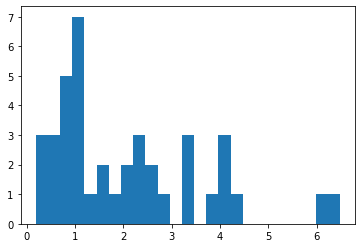

In [30]:
plt.hist(pupil_performance_df["average duration per task in minutes"], bins=int(np.max(pupil_performance_df["average duration per task in minutes"])/0.25))
plt.show()

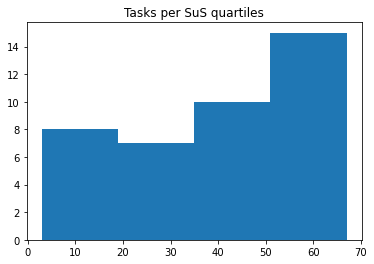

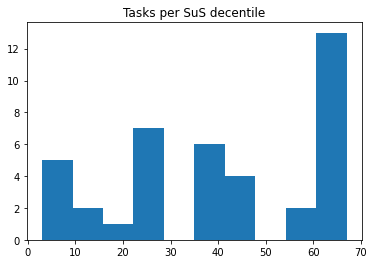

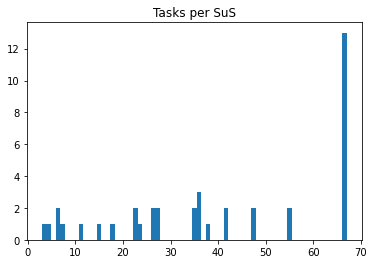

In [31]:
# anzahl tasks per pupil

plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=4)
plt.title("Tasks per SuS quartiles")
plt.show()
plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=10)
plt.title("Tasks per SuS decentile")
plt.show()
plt.hist(pupil_performance_df["nr_tasks_per_pupil"], bins=np.max(pupil_performance_df["nr_tasks_per_pupil"]))
plt.title("Tasks per SuS")
plt.show()

In [32]:
# Wie viele SuS haben die jeweilige Aufgabe gelöst?
df["taskId"].value_counts()

AI-1-v2-1-1    40
AI-1-v2-1-2    40
AI-1-v2-2-1    40
AI-2-v2-1-1    38
AI-3-v2-1-1    36
               ..
EvalML-1-8     16
EvalML-1-5     16
EvalML-1-6     16
EvalML-1-7     16
EvalML-1-2     16
Name: taskId, Length: 67, dtype: int64

## Fortschritt aller SuS im Paket

Mögliche Erklärung: Kein Präsenzunterricht wegen Corona?
Mögliche Erklärung: Nicht alle Lehrer haben das Paket zuende gespielt


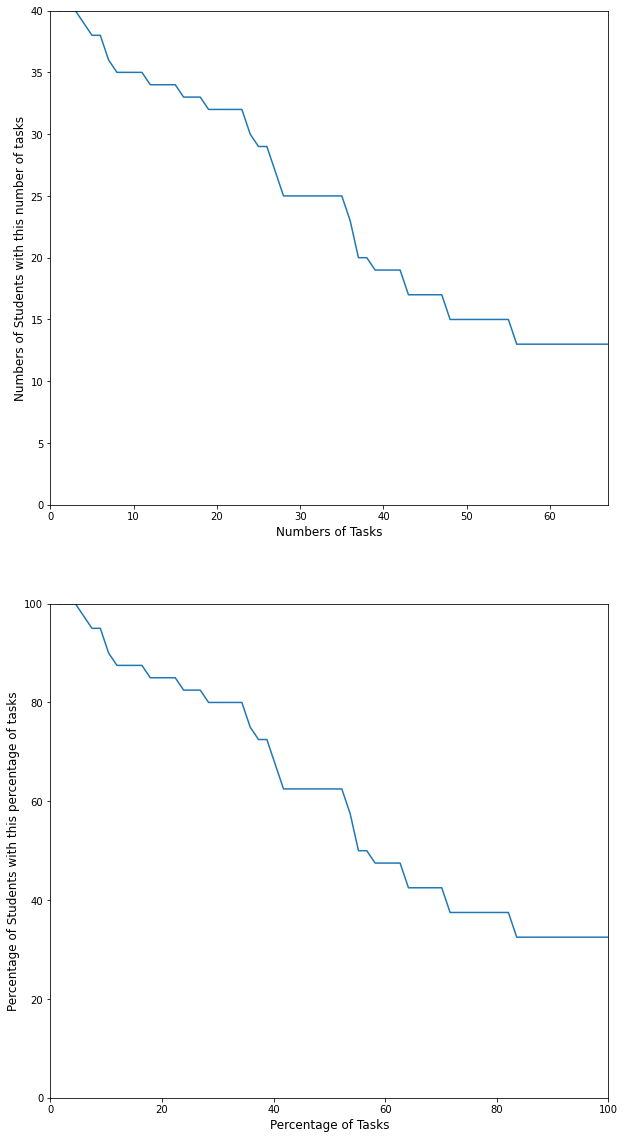

In [33]:
nr_all_tasks = len(df["taskId"].unique())

sorted_nr_tasks_per_pupil = np.sort(nr_tasks_per_pupil)

# Number of students with number of tasks
number_pupils_with_this_number_of_tasks = []
for i in range(nr_all_tasks):
    at_least_this_number = 0
    for number in sorted_nr_tasks_per_pupil:
        if number >= i+1:
            at_least_this_number += 1
    number_pupils_with_this_number_of_tasks.append(at_least_this_number) #anzahl zahlen mit mehr

# percentage of students with each percentage of tasks
task_percentage = [i * (100/nr_all_tasks) for i in range(1,nr_all_tasks+1)]
pupil_percentages = [i * (100/len(df["pupilId"].unique())) for i in number_pupils_with_this_number_of_tasks]


# PLOTTING
print("Mögliche Erklärung: Kein Präsenzunterricht wegen Corona?")
print("Mögliche Erklärung: Nicht alle Lehrer haben das Paket zuende gespielt")
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(10,20))

ax1 = plt.subplot(211)
ax1.plot(range(1,nr_all_tasks+1), number_pupils_with_this_number_of_tasks)
ax1.set_xlabel( "Numbers of Tasks" , size = 12 )
ax1.set_ylabel( "Numbers of Students with this number of tasks" , size = 12 )
ax1.set_xlim([0, nr_all_tasks])
ax1.set_ylim([0, len(sorted_nr_tasks_per_pupil)])

ax2 = plt.subplot(212)
ax2.plot(task_percentage, pupil_percentages)
ax2.set_xlabel( "Percentage of Tasks" , size = 12 )
ax2.set_ylabel( "Percentage of Students with this percentage of tasks" , size = 12 )
ax2.set_xlim([0, 100])
ax2.set_ylim([0, 100])

plt.show()

# Itemanalyse
## Surveyslider

AI-1-v2-1-1: Wie gut weißt du schon, was KI ist?
min: 5
max: 100
median: 71.5
mean: 69.0
std: 21.238571587489663


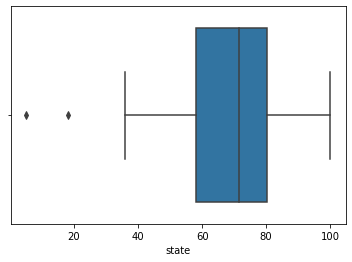

AI-4-v2-1-4: Wie gut hast du jetzt verstanden, was KI ist?
min: 40
max: 100
median: 86.0
mean: 79.06451612903226
std: 19.131014058975836


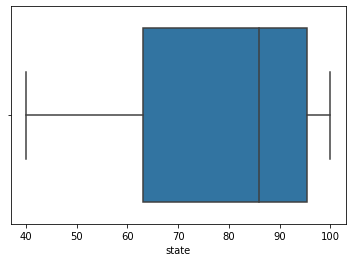

AI-4-v2-1-5: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
min: 33
max: 100
median: 88.0
mean: 78.96774193548387
std: 23.08749137659863


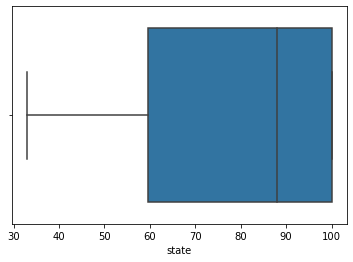

ML-2-1-1: Wie gut weißt du schon, was Maschinelles Lernen ist?
min: 47
max: 100
median: 66.0
mean: 69.51724137931035
std: 17.620241383248437


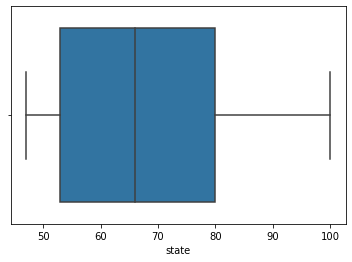

EvalML-1-1: Wie gut hast du verstanden, was KI ist? Sei dabei so ehrlich es geht damit wir diese Inhalte noch verbessern können.
min: 31
max: 100
median: 77.5
mean: 72.3125
std: 24.143235767670692


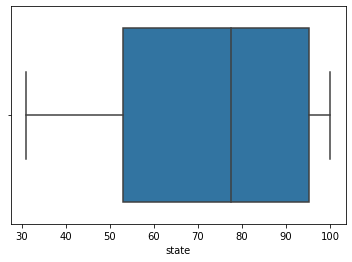

EvalML-1-2: Wie gut hast du den Unterschied zwischen spezifischer und allgemeiner KI verstanden?
min: 1
max: 100
median: 87.0
mean: 74.0625
std: 31.269727106793454


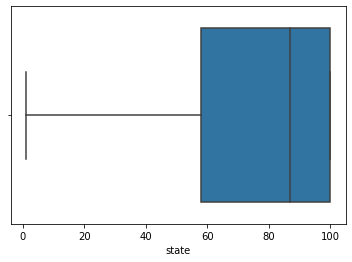

EvalML-1-5: Wie gut hast du verstanden, was maschinelles Lernen ist? Sei dabei so ehrlich es geht, damit wir diese Inhalte noch verbessern können.
min: 24
max: 100
median: 71.5
mean: 68.625
std: 22.559181427229728


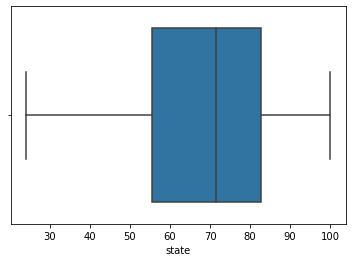

EvalML-1-6: Wie sehr hast du das Gefühl, verstanden zu haben, was der Unterschied zwischen überwachtem und unüberwachtem Lernen ist?
min: 37
max: 100
median: 73.5
mean: 74.5
std: 21.17545749210628


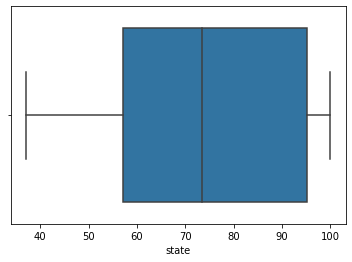

Impact-2-1-2: Ich würde gerne in einem Land leben, dass den Alltag aller Bürger mit KI überwacht.
min: 1
max: 100
median: 16.5
mean: 21.181818181818183
std: 23.613225437970463


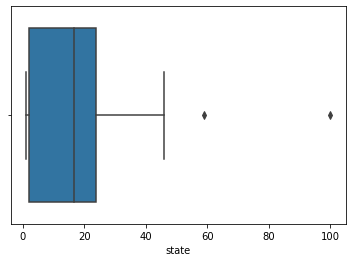

Impact-2-1-3: Die Überwachung des Alltags aller Bürger sehe ich sehr kritisch.
min: 15
max: 100
median: 80.5
mean: 78.13636363636364
std: 22.476009335978567


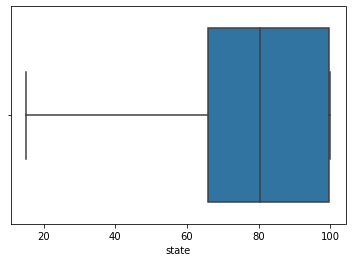

Impact-2-1-4: Mich würde es stören, mittels KI-Technologien überwacht zu werden.
min: 15
max: 100
median: 83.0
mean: 77.72727272727273
std: 24.765917090845825


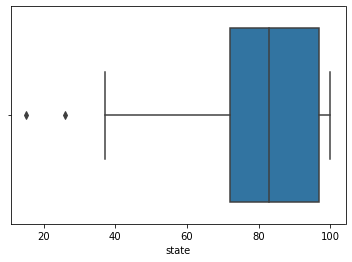

Impact-2-1-5: Die Überwachung durch die Regierung bietet viele Vorteile für die Gesellschaft.
min: 1
max: 85
median: 39.5
mean: 38.13636363636363
std: 27.18244436001445


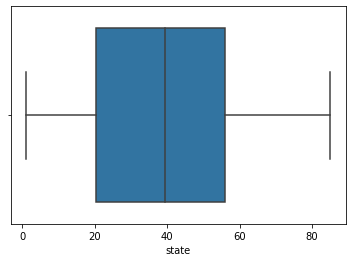

Impact-2-1-6: Ich würde nicht in einem Land leben wollen, dass meinen Alltag überwacht.
min: 1
max: 100
median: 84.0
mean: 75.95454545454545
std: 28.36744826754992


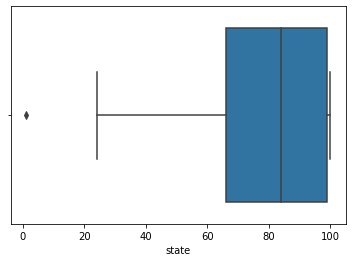

Impact-2-1-7: In einem Land mit Überwachung würde ich mich sehr sicher fühlen.
min: 1
max: 83
median: 41.5
mean: 39.81818181818182
std: 26.865868528206786


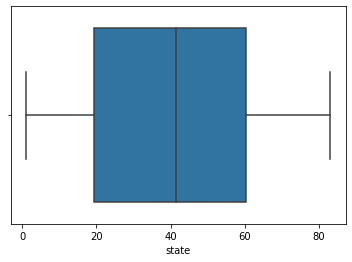

AIClosing-1-1: KI wird das Leben der Menschen verbessern.
min: 1
max: 100
median: 73.5
mean: 67.6
std: 29.517880397445456


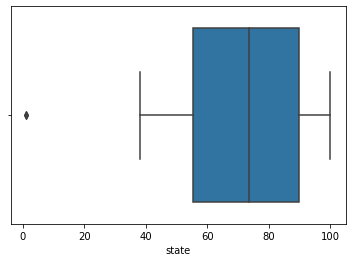

AIClosing-1-2: Bei der Entwicklung von KI gibt es Risiken, die bedacht werden müssen
min: 55
max: 100
median: 70.5
mean: 75.8
std: 16.922734630325593


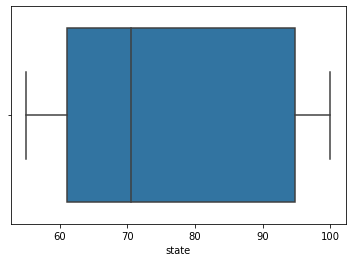

AIClosing-1-3: KI birgt eine Gefahr für die Menschheit.
min: 21
max: 100
median: 53.5
mean: 53.45
std: 22.22960330635468


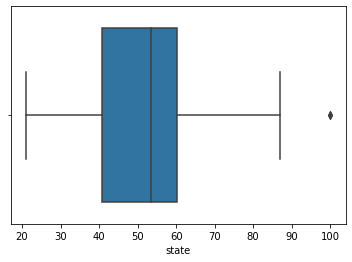

AIClosing-1-4: Die Vorteile durch die Entwicklung von KI überwiegen die Risiken.
min: 1
max: 100
median: 54.0
mean: 56.75
std: 28.76195403653931


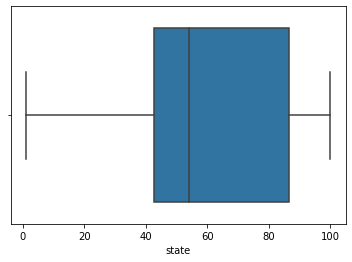

AIClosing-1-6: Hattest du Spaß?
min: 36
max: 100
median: 69.5
mean: 70.55
std: 19.93007513123927


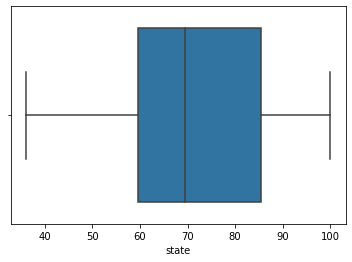

AIClosing-1-7: Hast du etwas gelernt?
min: 1
max: 100
median: 74.5
mean: 75.55
std: 22.476830175468297


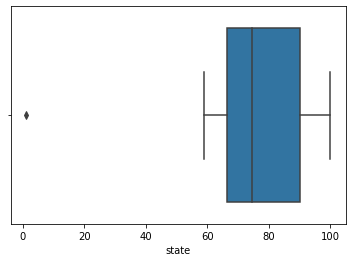

In [10]:
surveysliders = df[df["subType"]=="surveySlider"]
#surveysliders_by_taskId = df[df["subType"]=="surveySlider"].groupby("taskId")

for i in surveysliders["taskId"].unique():
    print(surveysliders[surveysliders["taskId"] == i]["taskId"].unique()[0] + ": " + surveysliders[surveysliders["taskId"] == i]["question"].unique()[0])
    print("min: " + str(surveysliders[surveysliders["taskId"] == i]["state"].min()))
    print("max: " + str(surveysliders[surveysliders["taskId"] == i]["state"].max()))
    print("median: " + str(surveysliders[surveysliders["taskId"] == i]["state"].median()))
    print("mean: " + str(surveysliders[surveysliders["taskId"] == i]["state"].mean()))
    print("std: " + str(surveysliders[surveysliders["taskId"] == i]["state"].std()))
    ax = sns.boxplot(x=surveysliders[surveysliders["taskId"] == i]["state"])
    plt.show()


## MC
### Barplot

['Die Personalisierung einer Google-Anfrage nutzt KI', 'Der Newsfeed eines Social Network nutzt KI', 'Die Startseite einer Webseite, die jedem Besucher die gleichen Inhalte anzeigt nutzt KI', 'Gesichtserkennung nutzt KI']


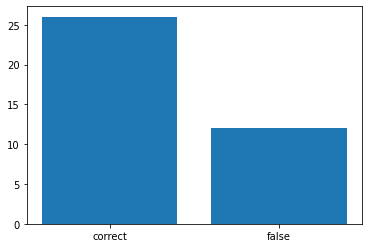

['Das Programm zur Gesichtserkennung auf deinem Handy kann auch Auto fahren', 'Die Anwendung, die den Facebook-Feed erstellt, kann auch Schach spielen', 'Eine Sprachsteuerung wie Siri oder Alexa kann auch Gesichter erkennen']


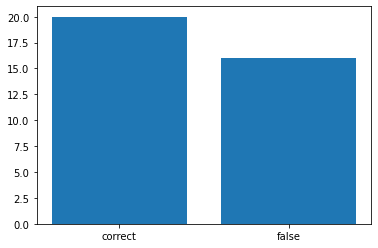

['Programme zur Bilderkennung gehören zur allgemeinen KI', 'Empfehlungssysteme gehören zur spezifischen KI', 'Eine KI aus einem Film, die eigenständige Entscheidungen trifft, mit Menschen spricht und sich am Ende gegen sie wendet, gehört zur allgemeinen KI']


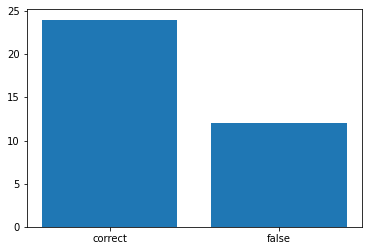

['KI-Anwendungen sind allgemein intelligent', 'Eine KI, die sich in einem einzigen Bereich so intelligent verhält wie ein Mensch, muss allgemeine Intelligenz besitzen', 'KI-Anwendungen zeigen intelligentes Verhalten in einem kleinen Bereich', 'Intelligentes Verhalten in einem spezifischen Bereich muss nicht gleich allgemeine Intelligenz bedeuten']


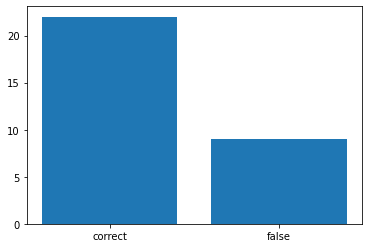

['KI-Anwendungen lernen durch Erfahrung', 'Intelligentes Verhalten setzt allgemeine Intelligenz voraus', 'Heutige KI-Anwendungen gehören alle zur spezifischen KI', 'Eine KI, die in allen Bereichen so schlau ist wie ein Mensch, gibt es noch nicht', 'Ein Spam-Filter ist eine allgemeinen KI', 'KI-Anwendungen treffen eigenständige Entscheidungen', 'Spezifische KI umfasst Anwendungen, die menschenähnliche Intelligenz in einem kleinen Bereich zeigen']


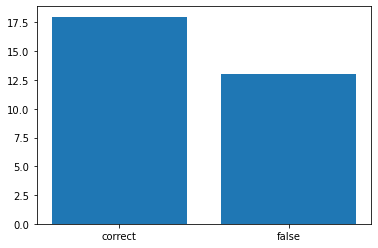

['Für das Training nutzen wir Daten ohne Label', 'Die Daten, die wir für das Training benutzen, heißen Trainingsdaten', 'Nach dem Training testen wir nochmal auf ein paar neuen Daten, wie gut die Vorhersagen des Algorithmus sind', 'Unser Ziel ist es, einen Algorithmus zu trainieren, der für neue Bilder das richtige Label vorhersagen kann. Also zu sagen, ob ein Bild einen Hund oder eine Katze zeigt']


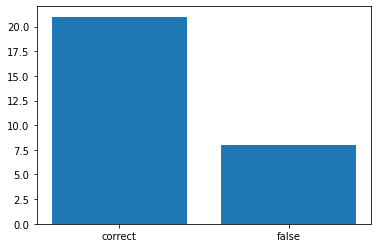

['Maschinelles Lernen ist ein Teilbereich der KI', 'Das überwachte und das unüberwachte Lernen unterscheiden sich zum Beispiel daran, dass wir einmal Daten mit und einmal Daten ohne Label nutzen', 'Beim unüberwachten Lernen wollen wir lernen, für neue Daten das richtige Label vorherzusagen', 'Das maschinelle Lernen beschäftigt sich mit Programmen, die selbständig in großen Datenmengen Gesetzmäßigkeiten erkennen können']


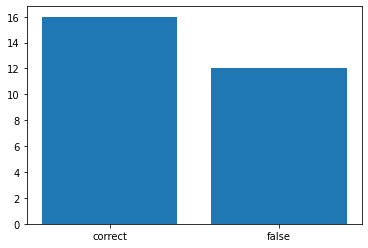

['Unüberwachtes Lernen', 'Überwachtes Lernen']


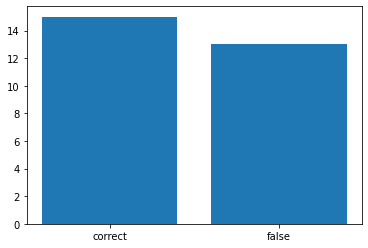

['Unüberwachtes Lernen', 'Überwachtes Lernen']


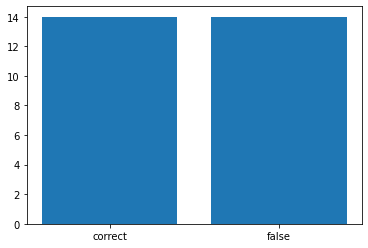

['Unüberwachtes Lernen', 'Überwachtes Lernen']


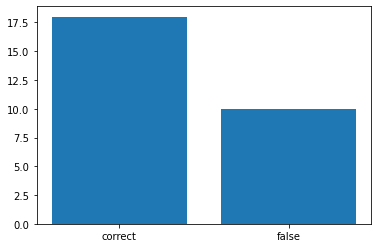

['Beim überwachten Lernen braucht man Daten ohne Label', 'Beim überwachten Lernen versucht man Struktur in Daten zu finden', 'Einen Algorithmus zu trainieren, der Bildern mit Hunden das Label “Hund” gibt, wäre ein Fall für überwachtes Lernen']


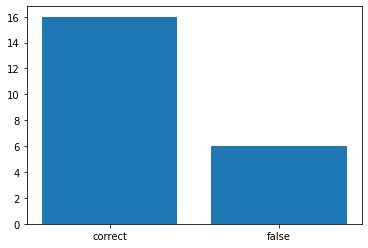

['Beim unüberwachten Lernen wollen wir die richtigen Label für neue Daten vorhersagen', 'Beim unüberwachten Lernen geht es darum, Struktur in den Daten zu finden', 'Beim unüberwachten Lernen hat man keine Label für die Daten', 'Beim unüberwachten Lernen nutzt man Daten mit Label']


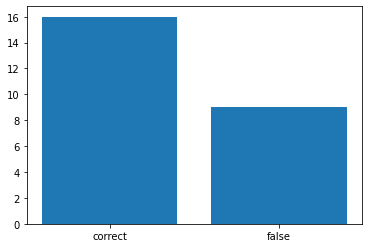

['Die Youtuber im blauen Cluster laden öfter Videos hoch', 'Die Youtuber im roten Cluster laden öfter Videos hoch']


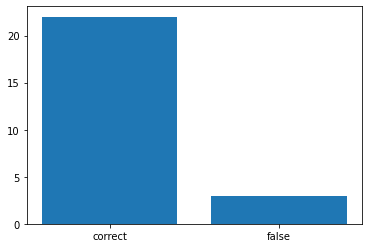

['Josi', 'Mahmud', 'Paul', 'Isa', 'Anna']


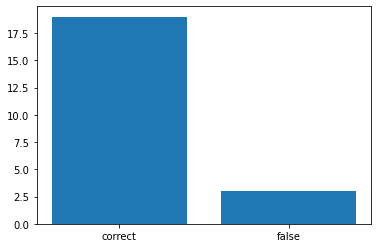

['James Bond', 'Fluch der Karibik', 'Avengers Endgame', 'Herr der Ringe', 'Hangover']


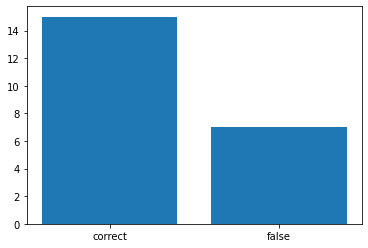

['Ein Algorithmus, der ähnliche Berufe gruppiert, gehört zum überwachten Lernen', 'Ein Algorithmus, der anhand vieler alter Fälle gelernt hat, medizinische Diagnosen zu stellen, gehört zum überwachten Lernen', 'Ein Algorithmus, der dir basierend auf deinen Lieblingsfächern einen Beruf vorschlägt, könnte man mittels überwachtem Lernen umsetzen']


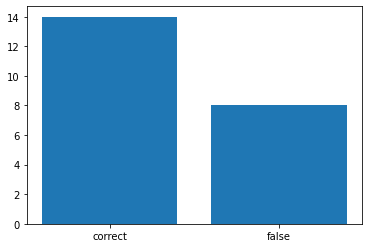

['Der Algorithmus würde nur Hunde dieser Rasse zuverlässig als Hunde erkennen', 'Der Algorithmus würde immer noch alle Hunderassen als Hunde erkennen, weil es keine Katzen sind', 'Bei Hunden anderer Rassen ist es schwer zu sagen, ob er sie erkennen würde, aber sehr wahrscheinlich nicht so zuverlässig']


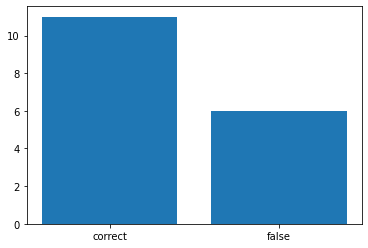

['Jede KI hat allgemeine Intelligenz. Damit ist jede KI eine allgemeine KI', 'Derzeit gibt es sowohl Anwendungen, die zur spezifischen, als auch welche, die zur allgemeinen KI gehören', 'Ein Programm, dass so gut Schach spielen kann, wie Menschen, ist ein Beispiel für eine spezifische KI', 'Eine spezifische KI zeigt intelligentes Verhalten in einem kleinen Bereich', 'Eine fertige KI-Anwendung kann nicht mit Erfahrung lernen, sie bleibt, wie sie ist', 'KI kann irgendwann alles besser als der Mensch', 'Jeder Mensch wird zukünftig eine Vielzahl verschiedener KIs in seinem Alltag nutzen', 'Eine fertige KI-Anwendung kann nicht ohne Hilfe von einem Menschen funktionieren', 'KI-Anwendungen zeichnen sich dadurch aus, dass sie intelligentes Verhalten zeigen, autonom funktionieren und mit Erfahrung lernen']


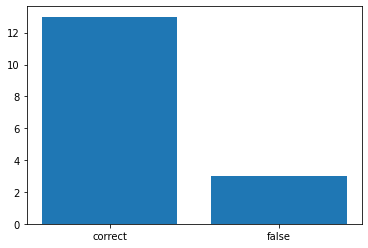

['Ein personalisiertes Empfehlungssystem für Musik', 'Das Sortieren von Bildern nach Datum', 'Die Erkennung von Gegenständen auf Bildern', 'Eine Nachrichtenseite, die jedem Nutzer den gleichen Inhalt präsentiert']


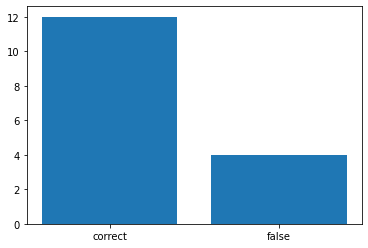

['Beim überwachten Lernen nutzen wir Daten ohne Label', 'Wenn wir für Daten Label vorhersagen wollen, betreiben wir Clustering', 'Clustering ist ein Beispiel für unüberwachtes Lernen', 'Algorithmen des maschinellen Lernens lernen nur, was in den Daten vorhanden ist. Daher ist die Auswahl an Trainingsdaten sehr wichtig', 'Wenn wir für Daten Label vorhersagen wollen, betreiben wir überwachtes Lernen', 'Beim unüberwachten Lernen versuchen wir, Strukturen in den Daten zu entdecken', 'Algorithmen des maschinellen Lernens können aus vorhandenen Daten selbständig lernen', 'Algorithmen des maschinellen Lernens benötigen oft große Mengen an Daten, damit sie gute Ergebnisse erzielen']


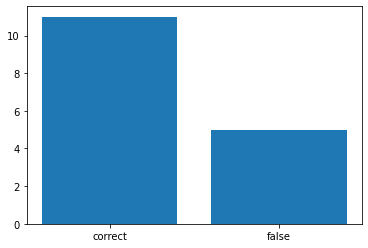

['Eine Webseite, die ähnliche Rezepte gruppiert, wäre eine Aufgabe für das Clustering', 'Eine Webseite, die für neue Rezepte vorhersagt, ob sie dir “gefallen” oder “nicht gefallen”, ist eine Aufgabe für das überwachte Lernen']


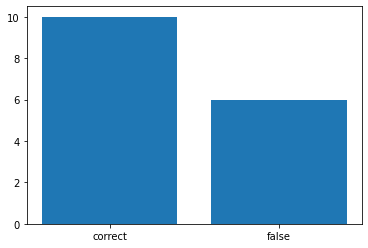

['Der Algorithmus wurde falsch programmiert', 'Die Trainingsdaten, mit denen der Algorithmus gelernt hat, enthielten keine oder kaum Bilder von dunkelhäutigen Menschen']


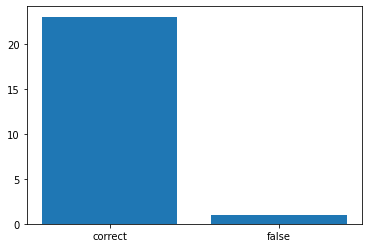

['LKW- und Taxifahrer', 'Angestellte im Kundenservice', 'Lehrer', 'Wissenschaftler', 'Angestellte bei einer Bank oder Versicherung', 'Pflegepersonal']


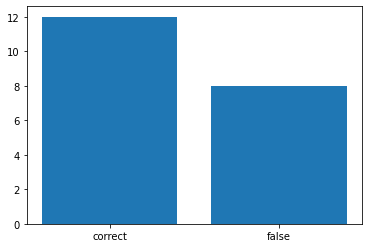

['KI-Methoden können immer die richtige Diagnose stellen', 'KI-Methoden werden Ärzte komplett ersetzen', 'KI kann helfen, die richtigen Behandlungen zu empfehlen', 'KI kann helfen, die Behandlungen besser an jeden einzelnen Patienten anzupassen', 'KI kann die Erkennung von Tumoren auf Scans verbessern', 'KI kann helfen, bessere Diagnosen zu stellen', 'KI kann die medizinische Versorgung günstiger machen']


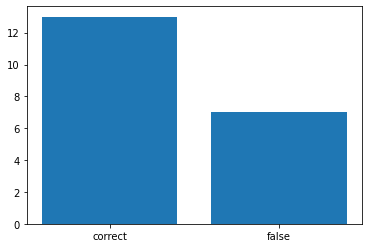

In [35]:
multipleChoice = df[df["subType"]=="multipleChoice"]

for i in multipleChoice["taskId"].unique():
    answers = []
    for answer in multipleChoice[multipleChoice["taskId"] == i]["answers"]:
        for answeritem in answer:
            #print(answeritem)
            answers.append(answeritem["de"])
    print(list(set(answers)))
    #sns.barplot(x="day", y="total_bill", data=tips)
    #sns.barplot(data=np.array(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()))
    plt.bar(["correct", "false"], np.array(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()))
    plt.show()

### True - False Ratio, Torten

In [88]:
for i in multipleChoice["taskId"].unique():
    if("correct" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys() and "false" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys()):
        print(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()["correct"]/multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts()["false"])
    elif("correct" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys() and not "false" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys()):
        print(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys())
    elif("correct" not in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys() and "false" in multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys()):
        print(multipleChoice[multipleChoice["taskId"] == i]["evaluation"].value_counts().keys())

7.333333333333333
2.0
5.0
2.6666666666666665
1.4444444444444444
9.0
2.6
1.0
0.8
8.0
15.0
3.5
Index(['correct'], dtype='object')
15.0
4.333333333333333
7.0
4.5
0.25
9.0
0.6666666666666666
9.0
Index(['correct'], dtype='object')
6.0
1.3333333333333333


## Freitext

In [11]:
freetext = df[df["subType"]=="freetext"]
freetext["state"]=freetext["state"].str.replace("<p>","")
freetext["state"]=freetext["state"].str.replace("</p>","")
print(str(len(freetext)) + " freetext tasks have been submitted")

268 freetext tasks have been submitted


/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
print(freetext.iloc[0]["state"])

Künstliche Intelligenz ist ein Algorithmus, der immer weiter dazu lernt um Aufgaben in den verschiedenste Bereichen zu erledigen.


In [13]:
freetext.head()

,pupilId,classId,taskId,taskSeriesId,duration,state,submitted,subType,evaluation,falseAttempts,hintsTaken,rating,teacherFeedback,question,answers,minLabel,maxLabel,hints,sampleSolution
1,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,AI-1-v2,119,"Künstliche Intelligenz ist ein Algorithmus, de...",True,freetext,correct,NaN,NaN,"{'content': 3, 'format': 5, 'creativity': 4}","Inhaltlich gut, etwas genauer antworten. Muste...",Was ist deiner Meinung nach Künstliche Intelli...,NaN,NaN,NaN,NaN,Die Schülerinnen und Schüler (SuS) sollen besc...
8,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-4-v2-1-3,AI-4-v2,285,"Eine KI ist ein Algorithmus, der auf eine best...",True,freetext,correct,NaN,NaN,"{'content': 5, 'format': 5, 'creativity': 5}",,Jetzt weißt du schon mehr über KI. Sag nochmal...,NaN,NaN,NaN,NaN,KI-Anwendungen zeichnen sich aus durch intelli...
11,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,ML-1-1-1,ML-1,203,"Einem Algorithmus, der Hunde auf Bildern erken...",True,freetext,correct,NaN,NaN,"{'content': 4, 'format': 5, 'creativity': 4}",,"Kannst du einen Algorithmus schreiben, der Hun...",NaN,NaN,NaN,NaN,Die SuS sollen sinnvolle Wenn-Dann-Regeln find...
16,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,ML-2-1-2,ML-2,219,Beim maschinellen Lernen wird der Algorithmus ...,True,freetext,correct,NaN,NaN,"{'content': 4, 'format': 5, 'creativity': 4}",,Weißt du vielleicht schon etwas über das masch...,NaN,NaN,NaN,NaN,"Das ist nur eine Abfrage, um über das Vorwisse..."
35,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,509,Für eine Make-Up-Marke würde ich am ehesten de...,True,freetext,correct,NaN,NaN,"{'content': 5, 'format': 4, 'creativity': 4}",,Schau dir die Mittelpunkte der Cluster genau a...,NaN,NaN,NaN,NaN,Make-Up: Cluster 1 repräsentiert es am besten....


### Länge der Abgaben

median length of freetext antwort: 20.5
mean length of freetext antwort: 27.813432835820894
std of length of freetext antwort: 23.631078673230604
50% are between 9.0 and 44.25 words long
min number of words: 1
max number of words: 119
Das sind nur die Längen der akzeptierten Antworten


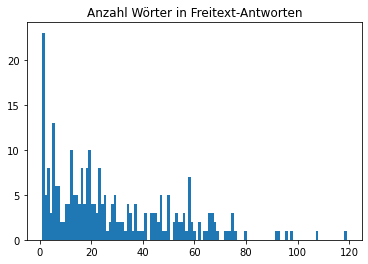

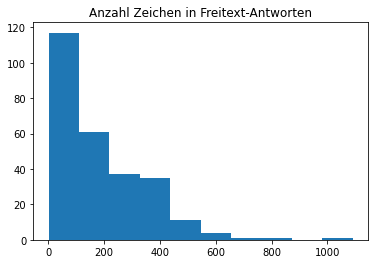

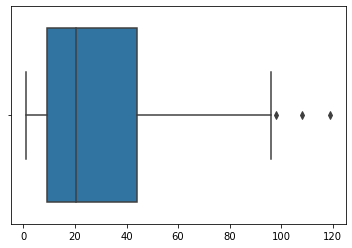

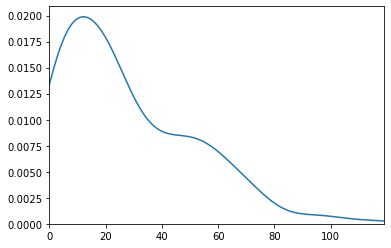

In [14]:
freetext_length_characters = []
freetext_length_words = []

for index, task in freetext.iterrows():
    freetext_length_characters.append(len(task["state"]))
    freetext_length_words.append(len(task["state"].split()))

print("median length of freetext antwort: " + str(np.median(freetext_length_words)))
print("mean length of freetext antwort: " + str(np.mean(freetext_length_words)))
print("std of length of freetext antwort: " + str(np.std(freetext_length_words)))

q75, q25 = np.percentile(freetext_length_words, [75 ,25])
print("50% are between " + str(q25) + " and " + str(q75) + " words long")

print("min number of words: " + str(np.min(freetext_length_words)))
print("max number of words: " + str(np.max(freetext_length_words)))
print("Das sind nur die Längen der akzeptierten Antworten")

plt.hist(freetext_length_words, bins=np.max(freetext_length_words))
plt.title("Anzahl Wörter in Freitext-Antworten")
plt.show()

plt.hist(freetext_length_characters)
plt.title("Anzahl Zeichen in Freitext-Antworten")
plt.show()

sns.boxplot(freetext_length_words)
plt.show()

kde_length = sns.kdeplot(freetext_length_words)
kde_length.set_xlim(left=0, right=np.max(freetext_length_words))
#kde_length.set_ylim(bottom=0, top=200);
plt.show()

In [15]:
freetext["number words in answer"] = [len(string.split()) for string in freetext["state"]]

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Kurze Antworten, die noch akzeptiert wurden

In [16]:
#was sind die kurzen antworten, die akzeptiert wurden?
freetext[(freetext["number words in answer"]<5) & (freetext["taskId"] != "AIClosing-1-8") & (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")][["pupilId", "classId", "taskId", "state", "question"]]

,pupilId,classId,taskId,state,question
885,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Impact-2-1-1,das Gesicht ist unscharf,Was für Probleme könnten durch den Einsatz von...
1066,iHYe2TGnR9zgGZ6zh,GkQSJvPTRWsLnpyR9,AI-4-v2-1-3,ja<br>,Jetzt weißt du schon mehr über KI. Sag nochmal...
1069,iHYe2TGnR9zgGZ6zh,GkQSJvPTRWsLnpyR9,ML-1-1-1,nö<br>,"Kannst du einen Algorithmus schreiben, der Hun..."
1093,iHYe2TGnR9zgGZ6zh,GkQSJvPTRWsLnpyR9,Clustering-2-1-1,.,Schau dir die Mittelpunkte der Cluster genau a...
1133,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,AI-4-v2-1-3,.,Jetzt weißt du schon mehr über KI. Sag nochmal...
1136,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,ML-1-1-1,.,"Kannst du einen Algorithmus schreiben, der Hun..."
1160,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,Clustering-2-1-1,.,Schau dir die Mittelpunkte der Cluster genau a...
1162,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,LimitsML-1-2,.,"Was würde passieren, wenn wir alle Bilder von ..."
1169,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,EvalML-1-7,.,"Beschreib noch einmal in eigenen Worten, was m..."
1173,5GPMWTgF29JDyeXoG,GkQSJvPTRWsLnpyR9,Impact-2-1-1,fehler,Was für Probleme könnten durch den Einsatz von...


Erst noch die Antworten auf Fragen rausnehmen, zu denen SuS noch nichts wissen müssen.
Scheinen wenige SuS zu sein, von denen die Antworten trotzdem akzeptiert wurden.

vllt musste ein account hochgespielt werden

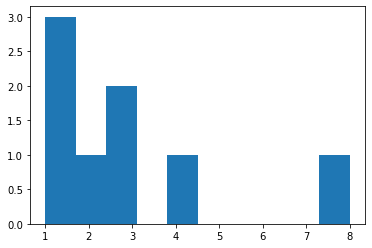

In [17]:
freetext[(freetext["number words in answer"]<5) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")]["pupilId"].value_counts()

plt.hist(freetext[(freetext["number words in answer"]<5) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")]["pupilId"].value_counts())
plt.show()

In [18]:
# kleiner als IQR25
freetext[(freetext["number words in answer"]<9) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")][["pupilId", "classId", "taskId", "state", "question"]]

,pupilId,classId,taskId,state,question
508,TLqNCrX4jaYixjtv7,qFEyvypMn4sAwLwtc,LimitsML-1-2,Dann erkennt der Algorithmus Seehunde als Hunde.,"Was würde passieren, wenn wir alle Bilder von ..."
760,3hiSwDCiw9HeyHg7f,qFEyvypMn4sAwLwtc,Impact-3-1-3,Es können Fehler von Menschenverhindert werden.,In vielen Bereichen wird der Mensch auch nicht...
818,jRT6yzZ2ip5ab5ZFM,qFEyvypMn4sAwLwtc,Impact-2-1-1,Man könnte damit verbrechen fälschen,Was für Probleme könnten durch den Einsatz von...
872,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Clustering-2-1-1,"<span style=""color: rgb(51, 51, 51);"">⠀</span>",Schau dir die Mittelpunkte der Cluster genau a...
874,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,LimitsML-1-2,"<span style=""color: rgb(51, 51, 51);"">⠀</span>","Was würde passieren, wenn wir alle Bilder von ..."
881,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,EvalML-1-7,"<span style=""color: rgb(51, 51, 51);"">⠀</span>...","Beschreib noch einmal in eigenen Worten, was m..."
885,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Impact-2-1-1,das Gesicht ist unscharf,Was für Probleme könnten durch den Einsatz von...
894,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,Impact-3-1-3,sicher werden die Kooperation mit Ki vorteile ...,In vielen Bereichen wird der Mensch auch nicht...
900,gooproPtWeTH6dtcB,qFEyvypMn4sAwLwtc,AIClosing-1-5,"<span style=""color: rgb(51, 51, 51);"">⠀</span>","Du siehst also, dass die Erwartungen der Mensc..."
1066,iHYe2TGnR9zgGZ6zh,GkQSJvPTRWsLnpyR9,AI-4-v2-1-3,ja<br>,Jetzt weißt du schon mehr über KI. Sag nochmal...


In [19]:
freetext[(freetext["number words in answer"]<9) & (freetext["taskId"] != "AIClosing-1-8")& (freetext["taskId"] != "ML-2-1-2")& (freetext["taskId"] != "AI-1-v2-1-2")]["pupilId"].value_counts()

5GPMWTgF29JDyeXoG    8
Qmv6K9aQsAEKfHsK9    6
Yss4MmFBusuAqSMaN    6
gooproPtWeTH6dtcB    6
iHYe2TGnR9zgGZ6zh    5
gDspq39jnffCNv8E2    4
jRT6yzZ2ip5ab5ZFM    1
TLqNCrX4jaYixjtv7    1
DK2rx5xPL6KCEobJE    1
3hiSwDCiw9HeyHg7f    1
eSpxJKMm99HohczFv    1
Name: pupilId, dtype: int64

### Gibt es noch pending antworten?

In [20]:
freetext[(freetext["evaluation"] == "pending")]

,pupilId,classId,taskId,taskSeriesId,duration,state,submitted,subType,evaluation,falseAttempts,hintsTaken,rating,teacherFeedback,question,answers,minLabel,maxLabel,hints,sampleSolution,number words in answer
175,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,845,Das 1. Cluster repräsentiert am Besten eine Ma...,True,freetext,pending,NaN,NaN,None,NaN,Schau dir die Mittelpunkte der Cluster genau a...,NaN,NaN,NaN,NaN,Make-Up: Cluster 1 repräsentiert es am besten....,96
376,Ay6mfswm3SFcQdNJg,qFEyvypMn4sAwLwtc,AIClosing-1-5,AIClosing,223,Die Bedenken die solche Personen äußern sind n...,True,freetext,pending,NaN,NaN,None,NaN,"Du siehst also, dass die Erwartungen der Mensc...",NaN,NaN,NaN,NaN,"Hier können die SuS nochmal alles, was sie übe...",48
379,Ay6mfswm3SFcQdNJg,qFEyvypMn4sAwLwtc,AIClosing-1-8,AIClosing,243,Ich fand das Design und die Idee dieser Plattf...,True,freetext,pending,NaN,NaN,None,NaN,Wir wollen diesen Kurs natürlich noch verbesse...,NaN,NaN,NaN,NaN,Die SuS können hier noch etwas loswerden. Ist ...,66
470,dotjrftFetJme4iPH,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,1154,Die Clusternummer 1 wäre für die Make-Up-Marke...,True,freetext,pending,NaN,NaN,None,NaN,Schau dir die Mittelpunkte der Cluster genau a...,NaN,NaN,NaN,NaN,Make-Up: Cluster 1 repräsentiert es am besten....,76
604,MRSj5LqwWj6WSoj4E,qFEyvypMn4sAwLwtc,ML-2-1-2,ML-2,445,Das maschinelles Lernen ist ein Begriff für da...,True,freetext,pending,NaN,NaN,None,NaN,Weißt du vielleicht schon etwas über das masch...,NaN,NaN,NaN,NaN,"Das ist nur eine Abfrage, um über das Vorwisse...",28
702,C2BW6tdii778v4RfL,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,189,"Cluster 1 repräsentiert eine Make-Up-Marke, da...",True,freetext,pending,NaN,NaN,None,NaN,Schau dir die Mittelpunkte der Cluster genau a...,NaN,NaN,NaN,NaN,Make-Up: Cluster 1 repräsentiert es am besten....,38
951,R8CkqGDeQXZmHxTuk,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,200,"Ich denke die nummer 1, weil mehr mädchen benu...",True,freetext,pending,NaN,NaN,None,NaN,Schau dir die Mittelpunkte der Cluster genau a...,NaN,NaN,NaN,NaN,Make-Up: Cluster 1 repräsentiert es am besten....,35
978,j3AkifkKRR3t3NeoT,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,406,"Ich denke, dass Cluster 1 am ehesten eine Make...",True,freetext,pending,NaN,NaN,None,NaN,Schau dir die Mittelpunkte der Cluster genau a...,NaN,NaN,NaN,NaN,Make-Up: Cluster 1 repräsentiert es am besten....,64


### Welche Antworten wurden nicht akzeptiert?

In [21]:
# evaluation kann sein: correct, pending, false
freetext[(freetext["evaluation"] == "false")]

# 7 abgaben, die nur einen punkt enthalten (2 davon wieder zu ML-2-1-2, also eig egal!).
# Bei einer Abgabe wurde der Text von Wikipedia kopiert
# eine war ein kurzer Satz
# Abgaben von 4 SuS
# Die Lehrer haben dabei nur an einer Stelle feedback gegeben!

'''
Lehrer geben nur wenig zurück! Und benutzen auch selten Feedback, oder?
'''

'\nLehrer geben nur wenig zurück! Und benutzen auch selten Feedback, oder?\n'

### Wurden Antworten mehrfach zurück gegeben?

In [36]:
for i, task in freetext[freetext["evaluation"] == "false"].iterrows():
    print(len(task["falseAttempts"]))

1
1
1
1
1
1
1
1
1


Es gibt keine Antworten, die mehrfach zurückgegeben wurden

### Teacher Feedback

In [43]:
freetext["teacherFeedback"].value_counts()

                                                                                                                              255
K.I. ist erstmal ein Programm, das in einem Computer angewandt wird, damit dieser beispielsweise Muster erkennt.                1
Tolle Antwort!                                                                                                                  1
Wikipedia kopiert!                                                                                                              1
Achte auf die Rechtschreibung bzw. Groß und Kleinschreibung. Inhaltlich könnte noch mehr kommen!                                1
Inhaltlich gut, etwas genauer antworten. Mustererkennung ist hier ein wichtiges Aufgabenbeispiel oder maschinelles Lernen.      1
Name: teacherFeedback, dtype: int64

Es wurde nur 5 mal Feedback gegeben:
* K.I. ist erstmal ein Programm, das in einem Computer angewandt wird, damit dieser beispielsweise Muster erkennt.
* Tolle Antwort!    
* Wikipedia kopiert!
* Achte auf die Rechtschreibung bzw. Groß und Kleinschreibung. Inhaltlich könnte noch mehr kommen!
* Inhaltlich gut, etwas genauer antworten. Mustererkennung ist hier ein wichtiges Aufgabenbeispiel oder maschinelles Lernen.

### Ratings

In [51]:
freetext[freetext["evaluation"] != "pending"]["rating"].value_counts()

TypeError: unhashable type: 'dict'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'dict'


{'content': 5, 'format': 5, 'creativity': 5}    116
{'content': 5, 'format': 5, 'creativity': 4}     34
{'content': 4, 'format': 5, 'creativity': 4}     21
{'content': 0, 'format': 0, 'creativity': 0}      7
{'content': 4, 'format': 4, 'creativity': 4}      7
{'content': 4, 'format': 3, 'creativity': 4}      7
{'content': 4, 'format': 5, 'creativity': 3}      5
{'content': 3, 'format': 4, 'creativity': 3}      5
{'content': 1, 'format': 1, 'creativity': 1}      5
{'content': 4, 'format': 4, 'creativity': 5}      5
{'content': 3, 'format': 4, 'creativity': 4}      4
{'content': 4, 'format': 2, 'creativity': 4}      4
{'content': 5, 'format': 3, 'creativity': 4}      4
{'content': 5, 'format': 4, 'creativity': 4}      4
{'content': 3, 'format': 5, 'creativity': 4}      3
{'content': 3, 'format': 2, 'creativity': 4}      3
{'content': 4, 'format': 3, 'creativity': 5}      2
{'content': 3, 'format': 3, 'creativity': 3}      2
{'content': 3, 'format': 5, 'creativity': 3}      2
{'content': 

In [22]:
# Added a columns for each rating 
rating_content = []
rating_format = []
rating_creativity = []

for i, task in freetext.iterrows():
    if(task["evaluation"] != "pending"):
        rating_content.append(task["rating"]["content"])
        rating_format.append(task["rating"]["format"])
        rating_creativity.append(task["rating"]["creativity"])
    else:
        rating_content.append(np.nan)
        rating_format.append(np.nan)
        rating_creativity.append(np.nan)
        

freetext["rating_content"] = rating_content    
freetext["rating_format"] = rating_format 
freetext["rating_creativity"] = rating_creativity

freetext.head()

/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,pupilId,classId,taskId,taskSeriesId,duration,state,submitted,subType,evaluation,falseAttempts,...,question,answers,minLabel,maxLabel,hints,sampleSolution,number words in answer,rating_content,rating_format,rating_creativity
1,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,AI-1-v2,119,"Künstliche Intelligenz ist ein Algorithmus, de...",True,freetext,correct,NaN,...,Was ist deiner Meinung nach Künstliche Intelli...,NaN,NaN,NaN,NaN,Die Schülerinnen und Schüler (SuS) sollen besc...,18,3.0,5.0,4.0
8,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,AI-4-v2-1-3,AI-4-v2,285,"Eine KI ist ein Algorithmus, der auf eine best...",True,freetext,correct,NaN,...,Jetzt weißt du schon mehr über KI. Sag nochmal...,NaN,NaN,NaN,NaN,KI-Anwendungen zeichnen sich aus durch intelli...,58,5.0,5.0,5.0
11,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,ML-1-1-1,ML-1,203,"Einem Algorithmus, der Hunde auf Bildern erken...",True,freetext,correct,NaN,...,"Kannst du einen Algorithmus schreiben, der Hun...",NaN,NaN,NaN,NaN,Die SuS sollen sinnvolle Wenn-Dann-Regeln find...,58,4.0,5.0,4.0
16,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,ML-2-1-2,ML-2,219,Beim maschinellen Lernen wird der Algorithmus ...,True,freetext,correct,NaN,...,Weißt du vielleicht schon etwas über das masch...,NaN,NaN,NaN,NaN,"Das ist nur eine Abfrage, um über das Vorwisse...",59,4.0,5.0,4.0
35,bniRycMi5bwrXjvGy,qFEyvypMn4sAwLwtc,Clustering-2-1-1,Clustering-2,509,Für eine Make-Up-Marke würde ich am ehesten de...,True,freetext,correct,NaN,...,Schau dir die Mittelpunkte der Cluster genau a...,NaN,NaN,NaN,NaN,Make-Up: Cluster 1 repräsentiert es am besten....,58,5.0,4.0,4.0


In [23]:
print("content")
print(freetext["rating_content"].value_counts())
print("format")
print(freetext["rating_format"].value_counts())
print("creativity")
print(freetext["rating_creativity"].value_counts())

content
5.0    164
4.0     55
3.0     24
0.0      7
1.0      5
2.0      5
Name: rating_content, dtype: int64
format
5.0    184
4.0     29
3.0     18
2.0     15
0.0      8
1.0      6
Name: rating_format, dtype: int64
creativity
5.0    128
4.0     94
3.0     22
0.0      9
1.0      5
2.0      2
Name: rating_creativity, dtype: int64


IQR75 Content Rating: 5.0
Median Content Rating: 5.0
IQR25 Content Rating: 4.0
Mean Content Rating: 4.334615384615384
Std Content Rating: 1.1366084190365908

IQR75 format Rating: 5.0
Median format Rating: 5.0
IQR25 format Rating: 4.0
Mean format Rating: 4.3307692307692305
Std format Rating: 1.2642325829010392

IQR75 creativity Rating: 5.0
Median creativity Rating: 4.0
IQR25 creativity Rating: 4.0
Mean creativity Rating: 4.196153846153846
Std creativity Rating: 1.1384810289391913



/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jean-philipp/Documents/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


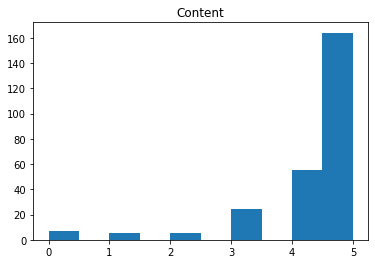

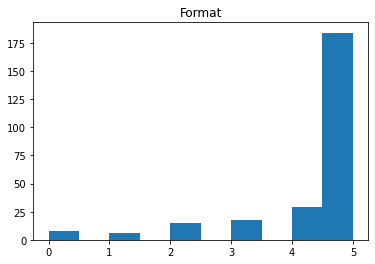

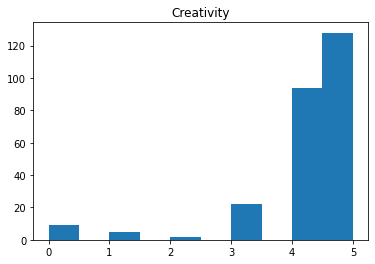

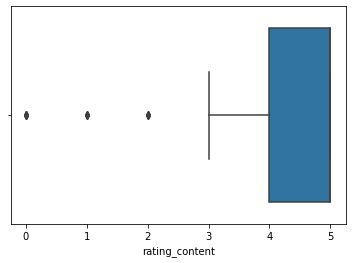

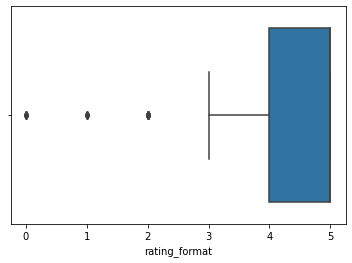

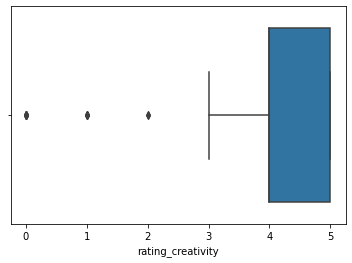

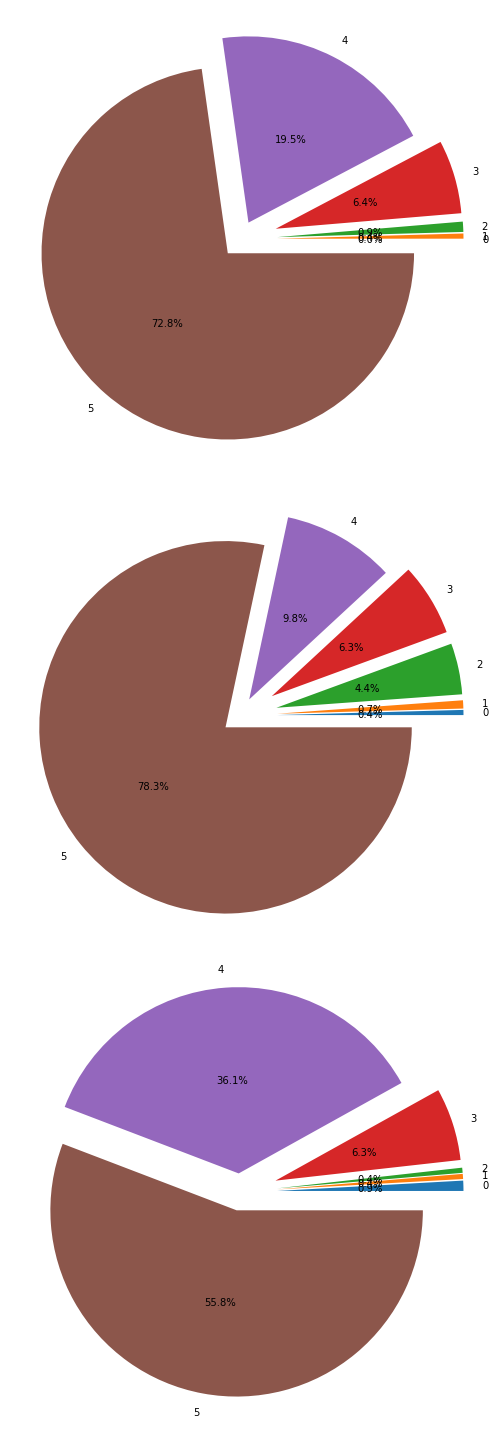

In [24]:
print("IQR75 Content Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_content"], 75)))
print("Median Content Rating: " + str(np.nanmedian(freetext["rating_content"])))
print("IQR25 Content Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_content"], 25)))
print("Mean Content Rating: " + str(np.mean(freetext["rating_content"])))
print("Std Content Rating: " + str(np.std(freetext["rating_content"])))
print("")

print("IQR75 format Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_format"], 75)))
print("Median format Rating: " + str(np.nanmedian(freetext["rating_format"])))
print("IQR25 format Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_format"], 25)))
print("Mean format Rating: " + str(np.mean(freetext["rating_format"])))
print("Std format Rating: " + str(np.std(freetext["rating_format"])))
print("")

print("IQR75 creativity Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_creativity"], 75)))
print("Median creativity Rating: " + str(np.nanmedian(freetext["rating_creativity"])))
print("IQR25 creativity Rating: " + str(np.percentile(freetext[freetext["evaluation"] != "pending"]["rating_creativity"], 25)))
print("Mean creativity Rating: " + str(np.mean(freetext["rating_creativity"])))
print("Std creativity Rating: " + str(np.std(freetext["rating_creativity"])))
print("")


plt.hist(freetext["rating_content"])
plt.title("Content")
plt.show()
plt.hist(freetext["rating_format"])
plt.title("Format")
plt.show()
plt.hist(freetext["rating_creativity"])
plt.title("Creativity")
plt.show()


#boxplots bringen eig nichts!
sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_content"])
plt.show()
sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_format"])
plt.show()
sns.boxplot(freetext[freetext["evaluation"] != "pending"]["rating_creativity"])
plt.show()


# Pie charts
content_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_content")["rating_content"].sum()
format_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_format")["rating_content"].sum()
creativity_data = freetext[freetext["evaluation"] != "pending"].groupby("rating_creativity")["rating_content"].sum()
labels = ["0", "1", "2", "3", "4", "5"]
#content_labels = freetext[freetext["evaluation"] != "pending"]["rating_content"].unique()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=[10,20])

ax1.pie(x=content_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
ax2.pie(x=format_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
ax3.pie(x=creativity_data, autopct="%.1f%%", explode = (0.2, 0.2, 0.2, 0.2, 0.1, 0.1), labels=labels, pctdistance=0.5)
plt.tight_layout()
plt.show()

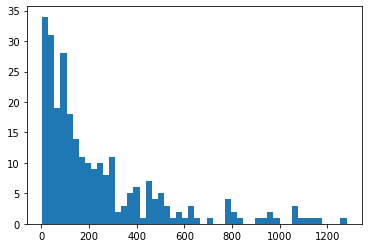

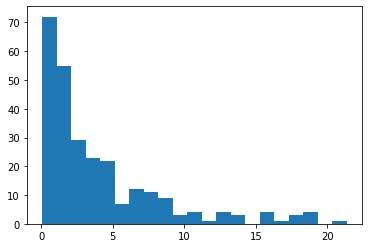

In [148]:
# durations
plt.hist(freetext["duration"], bins=50)
plt.show()

plt.hist(freetext["duration"]/60, bins=int(np.max(freetext["duration"])/60))
plt.show()

In [155]:
# Welche Antworten haben besonders lange gebraucht?
freetext[freetext["duration"] > 700][["pupilId", "classId", "taskId", "duration", "state", "number words in answer"]]

,pupilId,classId,taskId,duration,state,number words in answer
135,Kd6FuRsrq6QvPrkKp,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,979,"Künstliche Intelligenz heißt, dass ein Roboter...",55
141,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,968,"Künstliche Intelligenz bedeutet, dass ein Robo...",58
148,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,AI-4-v2-1-3,932,KI (Künstliche Intelligenz) unterscheidet man ...,108
175,6bBwnX2mwAp2NAwNR,qFEyvypMn4sAwLwtc,Clustering-2-1-1,845,Das 1. Cluster repräsentiert am Besten eine Ma...,96
381,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,818,Bei Künstlichen Intelligenzen wird durch das D...,34
396,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,ML-2-1-2,786,"Maschinelles Lernen wird auch ""deep learning"" ...",60
415,hn2oJ5p2CwPfG44wx,qFEyvypMn4sAwLwtc,Clustering-2-1-1,770,"Das Beauty, Vlogs repräsentiert am ehesten ein...",75
436,dotjrftFetJme4iPH,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,1063,"Meiner Meinung nach, künstliche Intelligenz is...",34
470,dotjrftFetJme4iPH,qFEyvypMn4sAwLwtc,Clustering-2-1-1,1154,Die Clusternummer 1 wäre für die Make-Up-Marke...,76
472,TLqNCrX4jaYixjtv7,qFEyvypMn4sAwLwtc,AI-1-v2-1-2,1125,Künstliche Intelligenz ist wenn Programme durc...,66


In [154]:
# Bei welchen Aufgaben sind die antworten besonders lang?
freetext[freetext["duration"] > 700]["taskId"].value_counts()

AI-1-v2-1-2         9
AI-4-v2-1-3         4
Clustering-2-1-1    3
ML-1-1-1            3
ML-2-1-2            1
Name: taskId, dtype: int64

In [167]:
# sind das die schüler, die dann auch nciht weit gekommen sind?
slow_freetext_pupils = freetext[freetext["duration"] > 700]["pupilId"].unique()

In [25]:
pupil_performance_df.head()

NameError: name 'pupil_performance_df' is not defined

In [172]:
#for pupilId in freetext[freetext["duration"] > 700]["pupilId"].unique():
#    print(pupil_performance_df[pupil_performance_df["pupilId"] == pupilId])

pupil_performance_df[pupil_performance_df["pupilId"].isin(slow_freetext_pupils)]

'''
manche nicht weit gekommen
die anderen sind eher langsame arbeiter, glaube ich
'''


,pupilId,nr_tasks_per_pupil,total_duration in minutes,average duration per task in minutes
2,Kd6FuRsrq6QvPrkKp,6,37.383333,6.230556
3,6bBwnX2mwAp2NAwNR,36,116.100000,3.225000
8,hn2oJ5p2CwPfG44wx,55,123.700000,2.249091
9,dotjrftFetJme4iPH,36,118.616667,3.294907
10,TLqNCrX4jaYixjtv7,47,124.450000,2.647872
11,kdqG4fXAK64zdrqN8,55,123.450000,2.244545
12,7eqvpzMXwFGaYWHou,11,43.800000,3.981818
13,Z9DkQMmtiPiHtteME,4,25.950000,6.487500
15,XKrLvRHLaM7yDisR6,23,91.550000,3.980435
17,C2BW6tdii778v4RfL,36,85.033333,2.362037


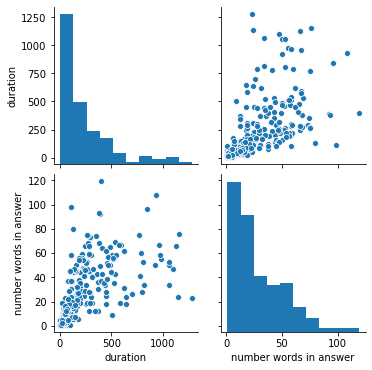

In [157]:
sns.pairplot(freetext[["duration", 'number words in answer']])


TypeError: No loop matching the specified signature and casting was found for ufunc svd_n_s

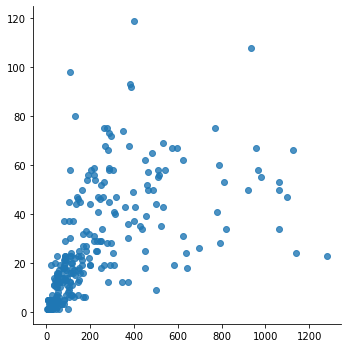

In [179]:
lmdata = freetext[freetext["evaluation"] != "pending"]
sns.lmplot(data=lmdata, x="duration", y="number words in answer")

# problem seems to be scipy: should be <1.3.0

In [26]:
# correlation mit kategorischen daten für ["duration", 'number words in answer', "rating_content", 'rating_format', 'rating_creativity']
rho1, p1 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['duration'], freetext[freetext["evaluation"] != "pending"]['rating_content'])
rho2, p2 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['duration'], freetext[freetext["evaluation"] != "pending"]['rating_format'])
rho3, p3 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['duration'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])
rho4, p4 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['number words in answer'], freetext[freetext["evaluation"] != "pending"]['rating_content'])
rho5, p5 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['number words in answer'], freetext[freetext["evaluation"] != "pending"]['rating_format'])
rho6, p6 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['number words in answer'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])

print("spearman coeff duration+content: " + str(rho1) + " p-value: " + str(p1))
print("spearman coeff duration+format: " + str(rho2) + " p-value: " + str(p2))
print("spearman coeff duration+creativity: " + str(rho3) + " p-value: " + str(p3))
print("spearman coeff answerlength+content: " + str(rho4) + " p-value: " + str(p4))
print("spearman coeff answerlength+format: " + str(rho5) + " p-value: " + str(p5))
print("spearman coeff answerlength+creativity: " + str(rho6) + " p-value: " + str(p6))

#unter 0.05 ist signifikant
# für coefficients nochmal nachschauen, ab wann wie stark

spearman coeff duration+content: -0.05774405609854682 p-value: 0.3537279037095544
spearman coeff duration+format: 0.07490480132060759 p-value: 0.22871495516461926
spearman coeff duration+creativity: -0.09021440397121602 p-value: 0.14688738819038427
spearman coeff answerlength+content: 0.006235424482870653 p-value: 0.9202969154973344
spearman coeff answerlength+format: 0.10091941779472066 p-value: 0.10446472334223415
spearman coeff answerlength+creativity: -0.07882070157663901 p-value: 0.20522913355889036


In [28]:
rho7, p7 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['rating_content'], freetext[freetext["evaluation"] != "pending"]['rating_format'])
rho8, p8 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['rating_content'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])
rho9, p9 = scipy.stats.spearmanr(freetext[freetext["evaluation"] != "pending"]['rating_format'], freetext[freetext["evaluation"] != "pending"]['rating_creativity'])

print("spearman coeff content+format: " + str(rho7) + " p-value: " + str(p7))
print("spearman coeff content+creat: " + str(rho8) + " p-value: " + str(p8))
print("spearman coeff format+creat: " + str(rho9) + " p-value: " + str(p9))

spearman coeff content+format: 0.6898912018686403 p-value: 4.5102844236676357e-38
spearman coeff content+creat: 0.6847138328329063 p-value: 2.5890141237812365e-37
spearman coeff format+creat: 0.5501659435236037 p-value: 5.675264570471399e-22


## Textfelder

# Hilfeanfragen

# Durations
## nach Aufgabentyp

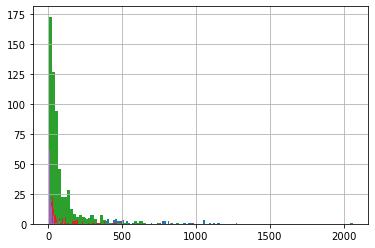

In [32]:
df.groupby("subType")["duration"].hist(bins=100)
# TODO: vllt als 3d histogram? https://matplotlib.org/stable/gallery/mplot3d/hist3d.html

for subType in df.groupby("subType"):
    #print(subType["duration"])
    #subType["duration"].hist()
    plt.show()
    
#groupby("taskId")
#groupby("pupilId")